<a href="https://colab.research.google.com/github/Andres8bit/Machine-Learning/blob/main/ResNetipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

In [22]:
def normalize_images(items):
  temp = np.zeros(shape=(items.shape))
  mean = np.mean(items,axis=(0,1,2,3))
  std = np.std(items,axis=(0,1,2,3))
  temp =(items - mean) /(std +1e-7)
  return temp

In [23]:
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [24]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [25]:
(x_train,x_valid) = x_train[5000:],x_train[:5000]
(y_train, y_valid) = y_train[5000:],y_train[:5000]

In [26]:
# Data Normalization:
x_train = normalize_images(x_train)
x_valid = normalize_images(x_valid)
x_test = normalize_images(x_test)

In [29]:
# One-Hot Encocding of lables:
y_train = np_utils.to_categorical(y_train,10)
y_valid = np_utils.to_categorical(y_valid,10)
y_test = np_utils.to_categorical(y_test,10)

In [32]:
# Data Augmentation:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=False
)

datagen.fit(x_train)

In [8]:
def bottleneck_residual_block(X,kernel_size,filters,reduce=False,stride_size=2):
  F1,F2,F3 = filters
  x_shortcut = X

  if reduce:
    # Reduce Path for shortcut:
    x_shortcut = Conv2D(filters=F3,kernel_size=(1,1),
                        strides=(stride_size,stride_size))(x_shortcut)
    x_shortcut = BatchNormalization(axis=3)(x_shortcut)
    
    X = Conv2D(filters=F1,kernel_size=(1,1),strides=(stride_size,stride_size),
               padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    x = Activation('relu')(X)
  else: 
    # 1st component of Main Path:
    X = Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
  # 2nd component of Main Path:
  X = Conv2D(filters=F2,kernel_size=kernel_size,strides=(1,1),padding='same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  # 3rd component of Main Path:
  X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
  X = BatchNormalization(axis=3)(X)

  # Final Step:
  X = Add()([X,x_shortcut])
  X = Activation('relu')(X)

  return X

In [16]:
def ResNet50(input_shape,classes):
  X_input = Input(input_shape)
  
  # 1st Block:
  X = Conv2D(64,(7,7),strides=(2,2),name='conv1')(X_input)
  X = BatchNormalization(axis=3,name='bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3),strides=(2,2))(X)

  # 2nd Block:
  X = bottleneck_residual_block(X,3,[64,64,256],reduce=True,stride_size=1)
  X = bottleneck_residual_block(X,3,[64,64,256])
  X = bottleneck_residual_block(X,3,[64,64,256])

  # 3rd Block:
  X = bottleneck_residual_block(X,3,[128,128,512],reduce=True,stride_size=2)
  X = bottleneck_residual_block(X,3,[128,128,512])
  X = bottleneck_residual_block(X,3,[128,128,512])
  X = bottleneck_residual_block(X,3,[128,128,512])

  # 4th Block:
  X = bottleneck_residual_block(X,3,[256,256,1024],reduce=True,stride_size=2)
  X = bottleneck_residual_block(X,3,[256,256,1024])
  X = bottleneck_residual_block(X,3,[256,256,1024])
  X = bottleneck_residual_block(X,3,[256,256,1024])
  X = bottleneck_residual_block(X,3,[256,256,1024])
  X = bottleneck_residual_block(X,3,[256,256,1024])

  # 5th Block:
  X = bottleneck_residual_block(X,3,[512,512,2048],reduce=True,stride_size=2)
  X = bottleneck_residual_block(X,3,[512,512,2048])
  X = bottleneck_residual_block(X,3,[512,512,2048])

  # AVG POOL:
  X = AveragePooling2D((1,1))(X)

  # Output:
  X = Flatten()(X)
  X = Dense(classes,activation='softmax',name='fc' + str(classes))(X)

  model = Model(inputs=X_input,outputs=X,name='ResNet50')

  return model

In [40]:
model = ResNet50((32,32,3),10)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 13, 13, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 13, 13, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 13, 13, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

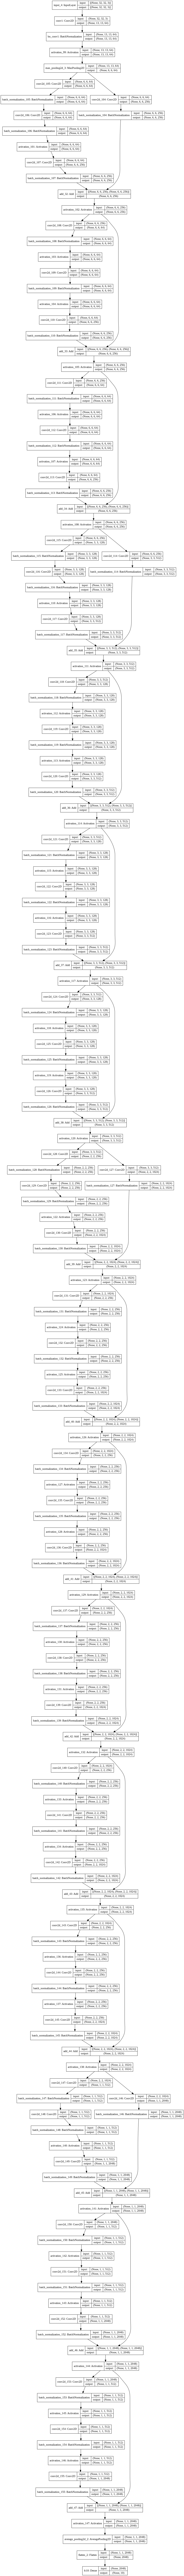

In [41]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [46]:
# Hyperparameters:
epochs = 64
batch_size = 32
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1),patience=5,min_lr=0.1e-4)

In [ ]:
# Compile and Fit model:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/20
 792/1407 [===============>..............] - ETA: 22:02 - loss: 2.2955 - accuracy: 0.2741